1. import all of the needed packages (check out the "neural_analysis" pipeline to see where to get the package "neurokin" from!)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import sys
import re
import shutil
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
import plotly.express as px
sys.path.append("../neurokin/")
from neurokin.utils.neural import processing, importing, neural_plot
from neurokin.utils.experiments import neural_states_helper, neural_correlates_plot, spider_factory
from neurokin.locomotion_states import NeuralCorrelatesStates
import json
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel, shapiro
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from neurokin.utils.experiments import neural_states_helper, neural_correlates_plot, spider_factory
from neurokin.locomotion_states import NeuralCorrelatesStates
from neurokin.neural_data import NeuralData

2. importing our dataframe

In [53]:
df_raw = pd.read_csv("df_raw_Dataframe_test.csv")

3. We will only take the right side, then we drop unnecessary columns 

In [54]:
df_right = df_raw[df_raw["SIDE"] == "RIGHT"]
df_right.drop(["SIDE", "FILENAME", "date", "RUN", "DOUBLE STANCE"], axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_12676\814435723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_right.drop(["SIDE", "FILENAME", "date", "RUN", "DOUBLE STANCE"], axis=1, inplace=True)


4. We use .groupby so that we get the median of every gait feature per condition per animal. A "side effect" of this is that the feature "healthy" gets converted from (True/False) to (1/0). The second line reverts this : 

In [55]:
grouped = df_right.groupby(["ANIMAL", "condition"], as_index=False).median(numeric_only=True)
grouped["healthy"] = grouped["healthy"].astype(bool)

5. Here we pick all of the conditions we want to take into our PCA / we want to visualize. Because for the healthy animals we only want to look at the Baseline condition, we drop all of the conditions for them that are not Baseline : 

In [56]:
df_picked = grouped[grouped["condition"].isin(["baseline", "cervical125", "lumbar125"])]
df_picked = df_picked.drop(df_picked[(df_picked["healthy"] == True) & (df_picked["condition"].isin(["cervical125", "lumbar125"]))].index)

6. We add a column that displays if an animal was from the season spring or fall :

In [57]:
df_picked["season"] = ["spring" if i in ["NWE00130",'NWE00131', 'NWE00158', 'NWE00160', 'NWE00161',
       'NWE00162', 'NWE00163', 'NWE00164', 'NWE00166'] else "fall" for i in df_picked["ANIMAL"]]

7. Next, we create a new dataframe to extract the metadata of our current dataframe. We do this because we don't want to normalize & run the PCA on that data. Only on our gait features! : 

In [58]:
metadata_df = df_picked[["ANIMAL", "condition", "healthy", "season"]].reset_index(drop=True)

8. splitting up df_picked into spring and fall and then dropping their metadata, because we want to normalize the seasons separately to get rid of inter-seasonal Variance : 

In [59]:
spring = df_picked[df_picked["season"] == "spring"]
spring_features = spring.drop(["ANIMAL", "condition", "healthy", "season"], axis=1)

fall = df_picked[df_picked["season"] == "fall"]
fall_features = fall.drop(["ANIMAL", "condition", "healthy", "season"], axis=1)

9. Then, we normalize the spring and fall dataframe separately and put them back together. We also convert them back into a pandas dataframe because through normalization, dataframes are converted into numpy arrays : 

In [66]:
x1 = preprocessing.scale(spring_features)
x2 = preprocessing.scale(fall_features)

x3 = np.concatenate([x1, x2], axis=0)

x3 = pd.DataFrame(x3)

10. Now, we can perform the PCA, create a dataframe with the PCA values and our desired amount of PC-columns. Lastly, we put together this dataframe with our priorly saved metadata dataframe : 

In [75]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x3)
principalDf = pd.DataFrame(principalComponents, columns=["PC1", "PC2", "PC3"])
principalDf = pd.concat([principalDf, metadata_df], axis=1)

11. We also add another column called "category" which shows us, if an animal was healthy or not and also the stimulation condition in one column. We need this to separate our groups when visualizing :

In [76]:
principalDf['category'] = np.where(principalDf['healthy'] == True,
                                 'healthy_baseline',
                                 np.where(principalDf['condition'] == 'baseline',
                                           'pda_baseline', np.where(principalDf['condition'] == 'cervical125', "pda_cervical",
                                           'pda_lumbar')))

12. We are now ready to visualize our PCA gait analysis : 
- We remove the axes labels and tick labels, so that we can add our own labels in a powerpoint for presenting results. 
- also, we change the plot to make it look like we want it to (remove spines to that we only see the x- & y-axis + relocate the legend) 

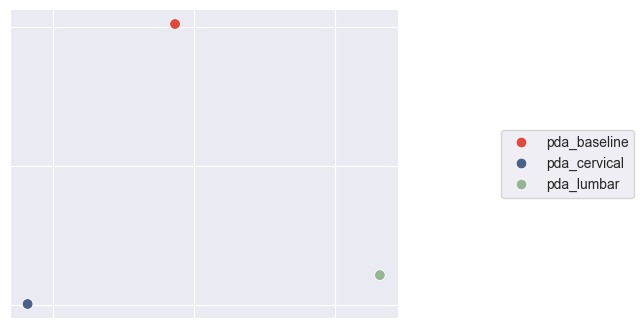

In [77]:
custom_palette = {"healthy_baseline": "#808080", "pda_baseline": "#e0493e", "pda_cervical": "#496186", "pda_lumbar": "#95b695"}

plt.figure(figsize=(5, 4))
g = sns.scatterplot(data=principalDf, x="PC2", y="PC1", hue="category", palette=custom_palette, s=60)

ax = plt.gca()
ax.set_xticks([-6, 0, 6])
ax.set_yticks([-6, 2, 10])
ax.tick_params(axis="both", which="both", length=5, width=1, direction="out", color="black")
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
g.spines[['right', 'top']].set_visible(False)
g.set(ylabel=None, xlabel=None)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
#plt.savefig("PCA_test.png", transparent=True)

13. This was the core Analysis. After that, we can also extract the loadings of e.g. PC1. Here, the loadings are the gait features that make up for the biggest variance in PC1. We select the top and bottom 3 gait features. 

In [79]:
all_features = df_picked.drop(metadata_df, axis=1)

feature_names = all_features.columns

loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2", "PC3"], index=feature_names)
sorted_loadings = loadings["PC1"].sort_values(ascending=False)

top_3_features = sorted_loadings.iloc[:3]
bottom_3_features = sorted_loadings.iloc[-3:]
selected_loadings = pd.concat([top_3_features, bottom_3_features])

14. Now let's visualize the loadings

[Text(0, 0.5, ''), Text(0.5, 0, '')]

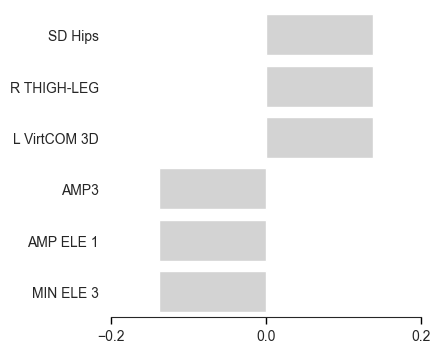

In [83]:
figure(figsize=(4, 4))
sns.set_style("ticks")  
b = sns.barplot(x=selected_loadings, y=selected_loadings.index, color="lightgray")

ax = plt.gca()
ax.set_xticks([-0.20, 0 , 0.20])
ax.tick_params(left=False, length=5, width=1, direction="out", color="black")

b.spines[['right', 'top', "left"]].set_visible(False)
b.set(ylabel=None, xlabel=None)

#plt.savefig("loadings_test.svg", transparent=True)